In this project we will recreate the analysis made by Mirabel et.al in 'Accretion instabilities and jet formation in GRS 1915+105'. This object emits a X-ray oscillating flux and the ejection of plasma clouds with very high energy partciles. data were collected by VLA on May 15 1997. The emission observed is consisten with a synchrotron emission from an adiabatically expanding blob, i.e., can be described with a van deer Laan model.

One of the easiest models to study the evolution of an expanding glob was proposed by van der laan, it consider that
$$
    N_0 \propto R^{-(2+p)}~~~~~~~~~~B\propto R^{-2}
$$

In this code we will calculate Brightness temperature, magnetic field, and the parameters of the power law describing the relativistic electron population. We assume a constant expansion of $0.2c$

# 1. Introduction.

Some usefull libraries.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

#gamma function
from scipy import special

#Fitting the spectrum
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
#Make a custom user model with units implementation
from astropy.modeling.core import Fittable1DModel, Parameter

from scipy.optimize import curve_fit

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

#Packages for using tables and units in astropy
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

#Astropy module to handle units
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B,m_e,e

#Packages to make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

Some functions that will be needed. Power law for the expanding radius and the expresions for magnetic field an dnumber density as a function of r.

In [83]:
def PLradius(time, speed, r0, a):
    """
    PLradius gives the radius after a given t of an expanding object with initial radius and a given speed driven by a power law

    Parameters
    :t: time of the expansion
    :v: speed of the expansion
    :r0: initial radius
    :a: parameter of the power law

    Output
    :r: radius at the end of the expansion
    """
    
    r=r0 + (speed*(time**a))
    return r

def Br(r, B0, r0):
    """
    Br returns the value of the magnetic field at a given r known the value B0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :B0: magnetic field at a starting radius
    :r0: radius at starting

    Output
    :Br: Magentic field at a radius r of the object
    """
    
    Br=B0*((r/r0)**(-2))
    return Br

def Nr(r, N0, r0, p):
    """
    Nr returns the value of the electron density at a given r known the value N0 at r0

    Parameters
    :r: radius at which the magnetic field will be calculated
    :N0: electron density at a starting radius
    :r0: radius at starting
    :p: exponent of the power law

    Output
    :Nr: electron density at a radius r of the object
    """
    
    Nr=N0*((r/r0)**(-(2+p)))
    return Nr

Let's read the data points and save it on a python table.

In [84]:
#Defining variables to save time and flux values of each point
time=[]
flux=[]
#Saving the table in a list where each element is a 2D array with the coordinates of the points
with open('Data/2cm.csv', 'r') as f:
    l = [[float(num.replace(',', '.')) for num in line.split()] for line in f]
#Saving time and flux of each point individually
for value in l:
    time.append(value[0])
    flux.append(value[1])
#Making a table out of the previus values
cm2= QTable([time*u.hour,flux*u.mJy],names=['UT time (hours)', 'Flux density (mJy)'], meta={'name': 'Light curves of GRS 1915+105 for May 15, 1997 obtained with the VLA at 2 cm'})

#Repeat for 3.6cm wavelenght
time=[] #Cleaning the list
flux=[]
with open('Data/3.6cm.csv', 'r') as f:
    l = [[float(num.replace(',', '.')) for num in line.split()] for line in f]
for value in l:
    time.append(value[0])
    flux.append(value[1])
cm3= QTable([time*u.hour,flux*u.mJy],names=['UT time (hours)', 'Flux density (mJy)'], meta={'name': 'Light curves of GRS 1915+105 for May 15, 1997 obtained with the VLA at 3.6 cm'})

#Repeat for 6cm wavelength
time=[]
flux=[]
with open('Data/6cm.csv', 'r') as f:
    l = [[float(num.replace(',', '.')) for num in line.split()] for line in f]
for value in l:
    time.append(value[0])
    flux.append(value[1])
cm6= QTable([time*u.hour,flux*u.mJy],names=['UT time (hours)', 'Flux density (mJy)'], meta={'name': 'Light curves of GRS 1915+105 for May 15, 1997 obtained with the VLA at 6 cm'})

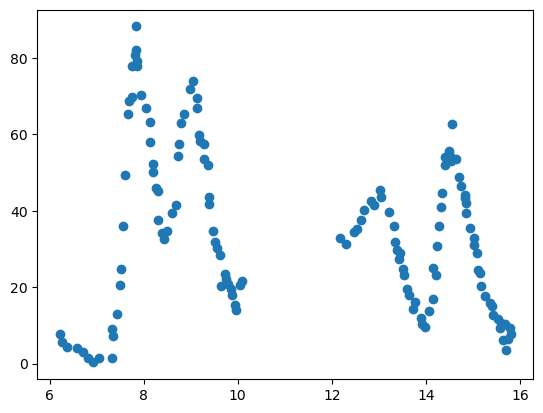

In [146]:
plt.scatter(cm2['UT time (hours)'],cm2['Flux density (mJy)'])

# 2. Calculus.

We want to make a least squares fit to our data, the expression to fit will be 
It is whown in the bibliografy that the intensity is
$$
    F_\nu = \Omega I_\nu = \frac{\pi R^2}{D^2}I_\nu,
$$
with
$$
    I_\nu = S(\nu_1) J\left( \frac{\nu}{\nu_1},p \right),
$$
is the frequency at the transition from thick to thin, where $S(\nu_1)= \frac{c_5}{c_6}B^{-1/2} \left( \frac{\nu_1}{2c_1} \right)^{5/2}$ is the source function at $\nu_1$ and $J(z, p)=z^{\frac{5}{2}}\left[1-\exp \left(-z^{-\frac{p+4}{2}}\right)\right]$. And $\nu_1$
$$
    \nu_1=2c_1(sc_6)^{\frac{2}{p+4}}N_0^{\frac{2}{p+4}}B^{\frac{p+2}{p+4}}~~Hz,
$$
where $c_6$, $c_5$ and $c_1$ are constants given by (Pacholcyzk)
$$
c_1=\frac{3 e}{4 \pi m^3 c^5}
$$

$$
c_5=\frac{\sqrt{3}}{16 \pi} \frac{e^3}{m c^2}\left(\frac{\gamma+7 / 3}{\gamma+1}\right) \Gamma\left(\frac{3 \gamma-1}{12}\right) \Gamma\left(\frac{3 \gamma+7}{12}\right)
$$

$$
c_6=\frac{\sqrt{3} \pi}{72} e m^5 c^{10}\left(\gamma+\frac{10}{3}\right) \Gamma\left(\frac{3 \gamma+2}{12}\right) \Gamma\left(\frac{3 \gamma+10}{12}\right)
$$

In [120]:
#First of all defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e**3*c**5)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in SI units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value
    
def calculatev1(s, p, N_0, B):
    """
    calculatev1 returns the value of the frequency at which the optical depth is 1 for a population of electron
    driven by a power law

    Parameters
    :s: Thickness of the source
    :p: Exponent of the power law of electron population
    :N_0: Constant multiplicative factor in the power law
    :B: Value of the magnetic field

    Output
    :v1: Frequency at which the optical depth is 1
    """

    #Computing the ressult, and giving it in Hz, since we do not know Pacholcyzk constannt units but we made
    #everything in cgs
    v1=(2*c1*(s*Pacholcyzk6(p))**(2/(p+4))*N_0**(2/(p+4))*B**((p+2)/(p+4)))
    return v1

Now let's deffine the functions needed for the intensity.

In [87]:
def SourceFunc(p, B, frequency):
    """
    Source returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :v: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """
    
    S=(Pacholcyzk5(p)/Pacholcyzk6(p)*B**(-1/2)*(frequency/(2*c1))**(5/2))
    return S

def JFunc(z, p):
    """
    Returns the value of the J function defined on the calculation of the intensity for a population
    of relativistic electrons driven by a power law of exponent p

    Paramenters
    :z: ratio of the frequency of interest and the frequency v1
    :p: Exponent of the power law

    Output
    :J:
    """

    J=z**(5/2)*(1-np.exp(-z**(-(p+4)/2)))
    return J

We can now compute the intensity and the flux.

In [88]:
def SpecInt(frequency, p, B, s, N0):
    """
    SpecInt returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :v: frequency at which the specific intensity is computed
    :p: exponent of the power law
    :B: Magnetic field
    :s: Thickness of the source
    :N0: Constant of the power law

    Output
    :I: specific intensity at the given frequency
    """
    
    v1=calculatev1(s, p, N0, B)
    I=SourceFunc(p, B, v1)*JFunc(frequency/v1, p)
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

In [89]:

def FluxatT(time, frequency, p, B0, N0, distance, r0, speed, a):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :time: Time at wich the flux is calculated
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B0: Magnetic field when radius is r0
    :N0: Constant of the power law
    :distance: Distance to the source
    :r0: reference radius of the source
    :speed: speed of the expansion
    :a: exponent of the power law describing expansion
    
    Output
    :F: Flux of the source
    """
    #Computing the radius at a given time
    r=PLradius(time, speed, r0, a)
    #Computing number density and magentic field for the corresponding r
    B=Br(r, B0, r0)
    N= Nr(r, N0, r0, p)
    
    F=solidangle(r, distance)*SpecInt(frequency, p, B, r, N)
    return F

We defined our function with frequencies, but sometimes data is given in wavelenght or viceversa, here we make some functions to change between them.

In [90]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

In [91]:
def Flux(frequency, p, B, s, N0, radius, distance):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :v: frequency at which the specific intensity is computed
    :p: exponent of the power law
    :B: Magnetic field
    :s: Thickness of the source
    :N0: Constant of the power law
    :r: radius of the source
    :D: Distance to the source

    Output
    :F: Flux of the source
    """

    F=solidangle(radius, distance)*SpecInt(frequency, p, B, s, N0)
    return SpecInt(frequency, p, B, s, N0)

Finally we can make a regression of the data to the flux function and get the values of $p$, $B_0$, $r_0$ and $N_0$. But first we need to separate the data in regions since

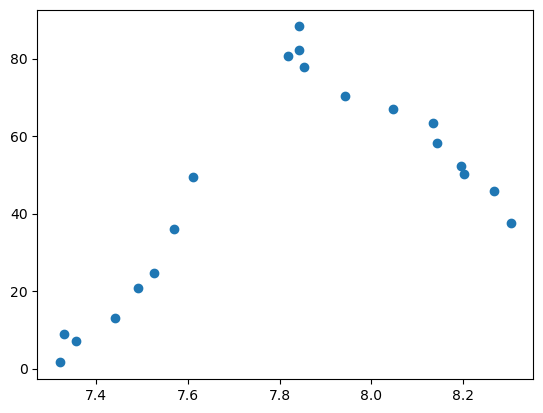

In [153]:
plt.scatter(cm2['UT time (hours)'][5:25],cm2['Flux density (mJy)'][5:25])

In [179]:
#Some initial parameters to initialice the model
p=2.5
r0= (10*3.0e6)*100.0*u.cm
d=8000*u.pc
B0= 1.0e3*u.G
N0= 1.0e12*u.erg**p/u.cm**3

#Frequency at wich we are observing the flux
frequency=wavelenghttofreq(6*u.cm)

x=cm2['UT time (hours)'][5:25].to(u.s).value
y=cm2['Flux density (mJy)'][5:25].to(u.Jy).value
alpha= curve_fit(FluxatT, x, y)
alpha

#Computing the values at r
#x=np.linspace(1.0, 500.0, 10000)
r=PLradius(x, (const.c/(3.0**0.5)).to(u.cm/u.s).value, r0.to(u.cm).value, 1.0)
omega= solidangle(r, d.to(u.cm).value)
B= Br(r, B0.to(u.G).value, r0.to(u.cm).value)
N= Nr(r, N0.to(u.erg**p/u.cm**3).value, r0.to(u.cm).value, p)

#Computing the flux at r
F1= Flux(frequency.to(u.Hz).value, p, B, r, N, r, d.to(u.cm).value)
alpha

(array([1., 1., 1., 1., 1., 1., 1., 1.]),
 array([[inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf, inf]]))

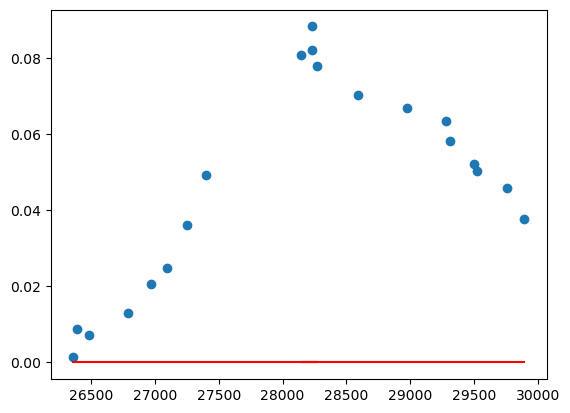

In [180]:
plt.scatter(x, y)
plt.plot(x, F1, c='red')
plt.show()

In [144]:
v1=calculatev1(r0.value, p, N0.value, B0.value)
I=SourceFunc(p, B0.value, v1)*JFunc(frequency.value/v1, p)
I

1.2002795934391402e-08

In [124]:
Pacholcyzk6(1.5)

9.694482374030553e-41

In [125]:
SourceFunc(p, B, v1)

array([1.91121969e+07, 1.99250953e+07, 2.07379937e+07, ...,
       8.14565750e+09, 8.14647040e+09, 8.14728330e+09])

In [130]:
v1=calculatev1(r, p, N, B)
#I=SourceFunc(p, B, v1)*JFunc(frequency/v1, p)

v1

array([2.52818893e+13, 2.28181692e+13, 2.06791605e+13, ...,
       8.50961182e+06, 8.50752179e+06, 8.50543249e+06])

In [106]:
B

array([2.18215562e-03, 2.00773378e-03, 1.85341837e-03, ...,
       1.20130878e-08, 1.20106904e-08, 1.20082938e-08])